In [10]:
import os
import csv
import ast
import pickle
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

from utils import savefig

plt.rcParams['font.size'] = 14

In [11]:
# def plot_mean_std_scatter(x, y, yerr, x_scatter, y_scatter, x_label, y_label, color='tab:blue', figname=None, vary_x=0.02):
#     fig = plt.figure(figsize=(4.3, 3.3), dpi=180)
#     plt.errorbar(np.array(x)-vary_x, y, yerr=yerr, fmt='o', alpha=0.8, capsize=3, color=color)
#     plt.scatter(np.array(x_scatter)+vary_x, y_scatter, alpha=0.3, color=color, s=15)
#     plt.xlabel(x_label)
#     plt.ylabel(y_label)
#     ax = plt.gca()
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     plt.tight_layout()
#     if figname:
#         savefig("./figures/vary_gamma", figname)
#     else:
#         plt.show()


def plot_mean_std_scatter(x, y, yerr, x_scatter, y_scatter, x_label, y_label, color='tab:blue', figname=None, vary_x=0.1):
    fig = plt.figure(figsize=(4.3, 3.3), dpi=180)
    plt.errorbar(np.arange(len(y))-vary_x, y, yerr=yerr, fmt='o', alpha=0.8, capsize=3, color=color)
    unique_x_values = np.unique(x_scatter)
    data_to_plot = [y_scatter[x_scatter == x_val] for x_val in unique_x_values]
    # plt.boxplot(data_to_plot, positions=np.arange(len(unique_x_values)) - vary_x, widths=0.1)
    
    # Update the scatter plot to use integer x-axis
    x_scatter_int = np.array([np.where(unique_x_values == x)[0][0] for x in x_scatter])
    plt.scatter(x_scatter_int + vary_x, y_scatter, alpha=0.3, color=color, s=15)
    plt.xticks(ticks=range(len(unique_x_values)), labels=[f"{x_val:.3f}" for x_val in unique_x_values])
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()
    if figname:
        savefig("./figures/vary_gamma", figname)
    else:
        plt.show()


def plot_scatter(x, y, x_label, y_label, color='tab:blue', figname=None):
    plt.figure(figsize=(4, 3.5), dpi=180)
    plt.scatter(x, y, alpha=0.5, color=color)

    # Reshape x and y for sklearn
    x_reshaped = np.array(x).reshape(-1, 1)
    y_reshaped = np.array(y).reshape(-1, 1)

    # Fit linear regression model
    model = LinearRegression()
    model.fit(x_reshaped, y_reshaped)

    # Predict y values
    sorted_x_idx = np.argsort(x_reshaped.reshape(-1))
    x1, x2 = x_reshaped[sorted_x_idx[0]], x_reshaped[sorted_x_idx[-1]]
    y_pred = model.predict(x_reshaped)
    y1, y2 = y_pred[sorted_x_idx[0]], y_pred[sorted_x_idx[-1]]

    # Calculate R-squared
    r2 = r2_score(y_reshaped, y_pred)

    # Plot the regression line
    plt.plot([x1, x2], [y1, y2], color=color)

    plt.ylabel(y_label)
    plt.xlabel(x_label+"\n(R² = {:.2f})".format(r2))

    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()
    if figname:
        savefig("./figures/scatter", figname)
    else:
        plt.show()

In [12]:
def load_data(path, training_data_path, eta, temporal_discount_factor, model_num, training_data_length=200):
    data_single_model = {}
    with open(path/"contiguity_effect.csv", "r") as f:
        reader = csv.reader(f)
        for row in reader:
            # if float(row[0]) >= performance_threshold:
            data_single_model["temporal_discount_factor"] = temporal_discount_factor
            data_single_model["eta"] = eta
            data_single_model["model_num"] = model_num
            data_single_model["accuracy"] = float(row[0])
            data_single_model["forward_asymmetry"] = float(row[1])
            data_single_model["temporal_factor"] = float(row[2])

            classifier_data = pickle.load(open(path/"ridge_classifier_stat.pkl", "rb"))
            data_single_model["index_decoding_accuracy_encoding_phase"] = classifier_data["index_enc_acc"]
            data_single_model["item_decoding_accuracy_encoding_phase"] = classifier_data["item_enc_acc"]
            data_single_model["last_item_decoding_accuracy_encoding_phase"] = classifier_data["item_enc_acc_last"]
            data_single_model["index_decoding_accuracy_recall_phase"] = classifier_data["index_rec_acc"]
            data_single_model["item_decoding_accuracy_recall_phase"] = classifier_data["item_rec_acc"]
            data_single_model["last_item_decoding_accuracy_recall_phase"] = classifier_data["item_rec_acc_last"]
            data_single_model["index_decoding_accuracy"] = (data_single_model["index_decoding_accuracy_encoding_phase"] + data_single_model["index_decoding_accuracy_recall_phase"]) / 2
            data_single_model["item_decoding_accuracy"] = (data_single_model["item_decoding_accuracy_encoding_phase"] + data_single_model["item_decoding_accuracy_recall_phase"]) / 2
            data_single_model["last_item_decoding_accuracy"] = (data_single_model["last_item_decoding_accuracy_encoding_phase"] + data_single_model["last_item_decoding_accuracy_recall_phase"]) / 2

            explained_variance_data = np.load(path/"explained_variance.npy")
            data_single_model["explained_variance_encoding_index"] = explained_variance_data[0]
            data_single_model["explained_variance_recall_index"] = explained_variance_data[1]
            data_single_model["explained_variance_index"] = (data_single_model["explained_variance_encoding_index"] + data_single_model["explained_variance_recall_index"]) / 2
            data_single_model["explained_variance_encoding_identity"] = explained_variance_data[2]
            data_single_model["explained_variance_recall_identity"] = explained_variance_data[3]
            data_single_model["explained_variance_identity"] = (data_single_model["explained_variance_encoding_identity"] + data_single_model["explained_variance_recall_identity"]) / 2

            cross_decoding_data = np.load(path/"cross_acc.npy")
            data_single_model["cross_decoding_accuracy_index_rec_enc"] = cross_decoding_data[0]
            data_single_model["cross_decoding_accuracy_identity_rec_enc"] = cross_decoding_data[1]
            data_single_model["cross_decoding_accuracy_index_enc_rec"] = cross_decoding_data[2]
            data_single_model["cross_decoding_accuracy_identity_enc_rec"] = cross_decoding_data[3]
            data_single_model["cross_decoding_accuracy_index"] = (data_single_model["cross_decoding_accuracy_index_rec_enc"] + data_single_model["cross_decoding_accuracy_index_enc_rec"]) / 2
            data_single_model["cross_decoding_accuracy_identity"] = (data_single_model["cross_decoding_accuracy_identity_rec_enc"] + data_single_model["cross_decoding_accuracy_identity_enc_rec"]) / 2

            try:
                training_data = np.load(training_data_path/"accuracy_2.npy")
            except:
                training_data = np.load(training_data_path/"accuracy_1.npy")
            # find the final consecutive zeros in the training data and set it to the last non-zero value
            zero_indices = np.where(training_data == 0)[0]
            if len(zero_indices) > 0:
                last_zero_index = zero_indices[0]
                training_data[last_zero_index:] = training_data[last_zero_index-1]
            if training_data.shape[0] < training_data_length:
                training_data = np.pad(training_data, (0, training_data_length - training_data.shape[0]), mode='constant', constant_values=training_data[-1])
            data_single_model["training_accuracy"] = training_data
    return data_single_model


## Vary temporal discount factor
### load data and create a pandas dataframe

In [4]:
data_folder = Path("./experiments/VaryGamma/figures/ValueMemoryGRU")
training_curve_folder = Path("./experiments/VaryGamma/saved_models/ValueMemoryGRU")
# gamma_names = ["0", "01", "02", "03", "04", "05", "06", "07", "08", "09", "10"]
gamma_names = ["0", "02", "04", "06", "08", "10"]
eta_names = ["0005", "001", "002", "004"]
# setup_names = os.listdir(data_folder)
# temporal_discount_factors = np.arange(0, 1.1, 0.2)
# temporal_discount_factors = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
temporal_discount_factors = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
etas = [0.005, 0.01, 0.02, 0.04]

setup_names = ["setup_eta{}_gamma{}".format(eta, gamma) for eta, gamma in zip(eta_names, gamma_names)]

data = []


for j, temporal_discount_factor in enumerate(temporal_discount_factors):
    for k, eta in enumerate(etas):
        setup_name = "setup_eta{}_gamma{}".format(eta_names[k], gamma_names[j])
        setup_name_pretrained = "setup_pretrain_eta{}_gamma{}".format(eta_names[k], gamma_names[j])
        for i in range(20):
            data_path = data_folder / setup_name / str(i)
            training_data_path = training_curve_folder / (setup_name + '-' + str(i))
            if os.path.exists(data_path/"contiguity_effect.csv"):
                data_single_model = load_data(data_path, training_data_path, eta, temporal_discount_factor, i)
                if data_single_model:
                    data_single_model["pretrained"] = False
                    data.append(data_single_model)

            data_path_pretrained = data_folder / setup_name_pretrained / str(i)
            training_data_path_pretrained = training_curve_folder / (setup_name_pretrained + '-' + str(i))
            if os.path.exists(data_path_pretrained/"contiguity_effect.csv"):
                data_single_model_pretrained = load_data(data_path_pretrained, training_data_path_pretrained, eta, temporal_discount_factor, i)
                if data_single_model_pretrained:
                    data_single_model_pretrained["pretrained"] = True
                    data.append(data_single_model_pretrained)

            
df_tdf = pd.DataFrame(data)
df_tdf.head()

# save the dataframe
df_tdf.to_csv("./figures/fr_paper/saved_data/df_tdf_eta.csv", index=False)


In [13]:
# for the no pre-train, gamma from 0.8 to 1.0 version
data_folder = Path("./experiments/VaryGamma2/figures/ValueMemoryGRU")
training_curve_folder = Path("./experiments/VaryGamma2/saved_models/ValueMemoryGRU")

gamma_names = ["08", "085", "09", "095", "099", "0999", "09999"]
temporal_discount_factors = [0.8, 0.85, 0.9, 0.95, 0.99, 0.999, 0.9999]
eta = 0.02

setup_names = ["setup_gamma{}".format(gamma) for gamma in gamma_names]
data = []

for j, temporal_discount_factor in enumerate(temporal_discount_factors):
    setup_name = setup_names[j]
    for i in range(20):
        data_path = data_folder / setup_name / str(i)
        training_data_path = training_curve_folder / (setup_name + '-' + str(i))
        if os.path.exists(data_path/"contiguity_effect.csv"):
            data_single_model = load_data(data_path, training_data_path, eta, temporal_discount_factor, i)
            if data_single_model:
                data.append(data_single_model)


df_tdf = pd.DataFrame(data)
df_tdf.head()

df_tdf.to_csv("./figures/fr_paper/saved_data/df_tdf2.csv", index=False)

In [7]:
df_tdf = pd.read_csv("./figures/fr_paper/saved_data/df_tdf_eta.csv")
# print(df_tdf["training_accuracy"])
df_tdf["training_accuracy"] = df_tdf["training_accuracy"].apply(ast.literal_eval)
df_tdf["training_accuracy"] = df_tdf["training_accuracy"].apply(np.array)
training_accuracy_sample = df_tdf["training_accuracy"].iloc[0]


# filter data
performance_threshold = 0.7
df_tdf = df_tdf[df_tdf["accuracy"] >= performance_threshold]

### average training curve by temporal discount factor

In [12]:
training_accuracy_by_tdf = df_tdf[(df_tdf["pretrained"] == True) & (df_tdf["eta"] == 0.01) & (df_tdf["accuracy"] >= 0.7)]["training_accuracy"]


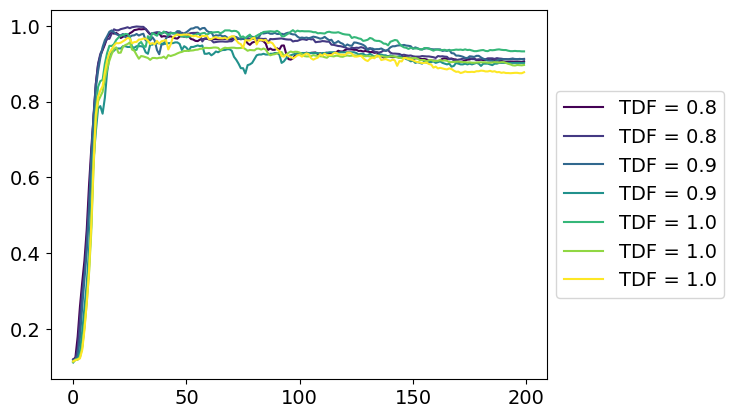

In [7]:
# training_accuracy_by_tdf = df_tdf[(df_tdf["pretrained"] == True) & (df_tdf["eta"] == 0.01)].groupby("temporal_discount_factor")["training_accuracy"].mean()
training_accuracy_by_tdf = df_tdf.groupby("temporal_discount_factor")["training_accuracy"].mean()

colors = plt.cm.viridis(np.linspace(0, 1, len(training_accuracy_by_tdf)))
for i, (tdf, acc) in enumerate(training_accuracy_by_tdf.items()):
    plt.plot(acc[:200], label=f"TDF = {tdf:.1f}", color=colors[i])
# set the legend to the right of the plot
ax = plt.gca()
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()


### plot the average accuracy, temporal factor, and forward asymmetry by temporal discount factor

In [14]:
# df_tdf_fixed_eta = df_tdf[(df_tdf["pretrained"] == True) & (df_tdf["eta"] == 0.01) & (df_tdf["accuracy"] >= 0.7)]
df_tdf_fixed_eta = df_tdf[df_tdf["accuracy"] >= 0.7]

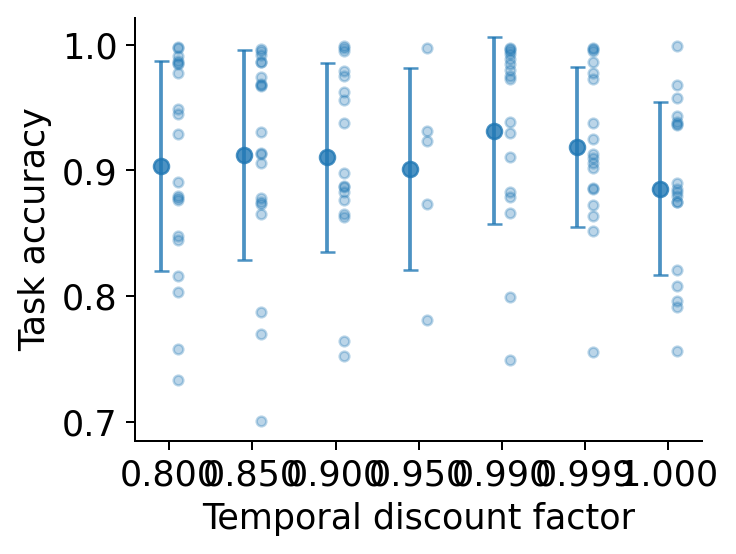

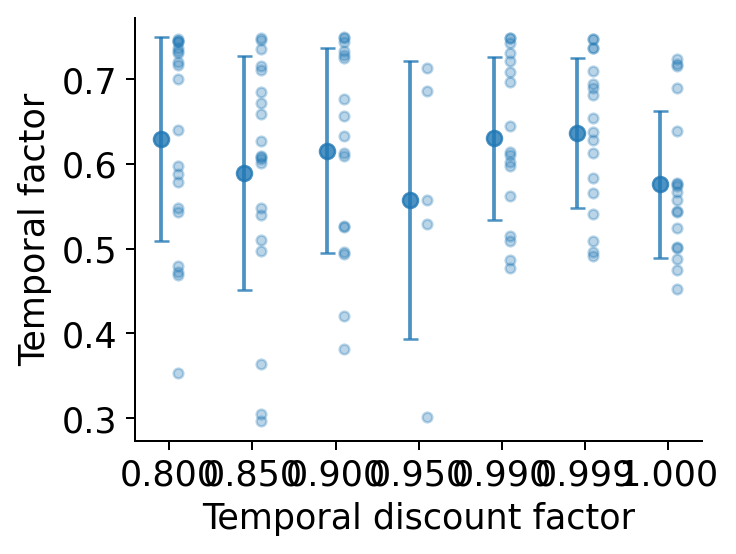

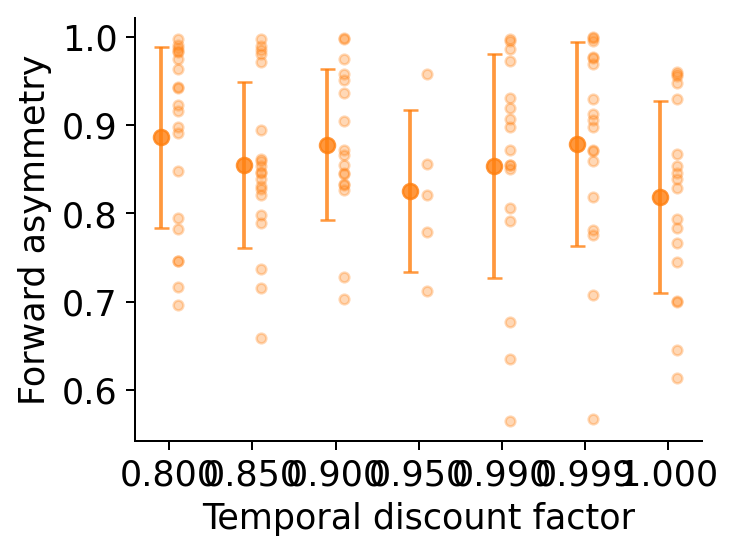

In [15]:
accuracy_mean_by_tdf = df_tdf_fixed_eta.groupby("temporal_discount_factor")["accuracy"].mean()
accuracy_std_by_tdf = df_tdf_fixed_eta.groupby("temporal_discount_factor")["accuracy"].std()

temporal_factor_mean_by_tdf = df_tdf_fixed_eta.groupby("temporal_discount_factor")["temporal_factor"].mean()
temporal_factor_std_by_tdf = df_tdf_fixed_eta.groupby("temporal_discount_factor")["temporal_factor"].std()

forward_asymmetry_mean_by_tdf = df_tdf_fixed_eta.groupby("temporal_discount_factor")["forward_asymmetry"].mean()
forward_asymmetry_std_by_tdf = df_tdf_fixed_eta.groupby("temporal_discount_factor")["forward_asymmetry"].std()

tdf_all = df_tdf_fixed_eta["temporal_discount_factor"]
accuracy_all = df_tdf_fixed_eta["accuracy"]
forward_asymmetry_all = df_tdf_fixed_eta["forward_asymmetry"]
temporal_factor_all = df_tdf_fixed_eta["temporal_factor"]
temporal_discount_factors = df_tdf_fixed_eta["temporal_discount_factor"].unique()


### plot the average accuracy, temporal factor, forward asymmetry and index decoding accuracy by temporal discount factor



# plot_mean_std(temporal_discount_factors, accuracy_mean_by_tdf, accuracy_std_by_tdf, "Temporal discount factor", "Task accuracy", color='tab:blue')
# plot_mean_std(temporal_discount_factors, temporal_factor_mean_by_tdf, temporal_factor_std_by_tdf, "Temporal discount factor", "Temporal factor", color='tab:blue')
# plot_mean_std(temporal_discount_factors, forward_asymmetry_mean_by_tdf, forward_asymmetry_std_by_tdf, "Temporal discount factor", "Forward asymmetry", color='tab:orange')

plot_mean_std_scatter(temporal_discount_factors, accuracy_mean_by_tdf, accuracy_std_by_tdf, tdf_all, accuracy_all, "Temporal discount factor", "Task accuracy", color='tab:blue')
plot_mean_std_scatter(temporal_discount_factors, temporal_factor_mean_by_tdf, temporal_factor_std_by_tdf, tdf_all, temporal_factor_all, "Temporal discount factor", "Temporal factor", color='tab:blue')
plot_mean_std_scatter(temporal_discount_factors, forward_asymmetry_mean_by_tdf, forward_asymmetry_std_by_tdf, tdf_all, forward_asymmetry_all, "Temporal discount factor", "Forward asymmetry", color='tab:orange')



In [ ]:
# decoding accuracy by temporal discount factor
index_decoding_accuracy_encoding_phase_mean_by_tdf = df_tdf_fixed_eta.groupby("temporal_discount_factor")["index_decoding_accuracy_encoding_phase"].mean()
index_decoding_accuracy_encoding_phase_std_by_tdf = df_tdf_fixed_eta.groupby("temporal_discount_factor")["index_decoding_accuracy_encoding_phase"].std()
index_decoding_accuracy_encoding_phase_all = df_tdf_fixed_eta["index_decoding_accuracy_encoding_phase"]

# item_decoding_accuracy_encoding_phase_mean_by_tdf = df_tdf.groupby("temporal_discount_factor")["item_decoding_accuracy_encoding_phase"].mean()
# item_decoding_accuracy_encoding_phase_std_by_tdf = df_tdf.groupby("temporal_discount_factor")["item_decoding_accuracy_encoding_phase"].std()

# last_item_decoding_accuracy_encoding_phase_mean_by_tdf = df_tdf.groupby("temporal_discount_factor")["last_item_decoding_accuracy_encoding_phase"].mean()
# last_item_decoding_accuracy_encoding_phase_std_by_tdf = df_tdf.groupby("temporal_discount_factor")["last_item_decoding_accuracy_encoding_phase"].std()

index_decoding_accuracy_recall_phase_mean_by_tdf = df_tdf_fixed_eta.groupby("temporal_discount_factor")["index_decoding_accuracy_recall_phase"].mean()
index_decoding_accuracy_recall_phase_std_by_tdf = df_tdf_fixed_eta.groupby("temporal_discount_factor")["index_decoding_accuracy_recall_phase"].std()
index_decoding_accuracy_recall_phase_all = df_tdf_fixed_eta["index_decoding_accuracy_recall_phase"]

# item_decoding_accuracy_recall_phase_mean_by_tdf = df_tdf.groupby("temporal_discount_factor")["item_decoding_accuracy_recall_phase"].mean()
# item_decoding_accuracy_recall_phase_std_by_tdf = df_tdf.groupby("temporal_discount_factor")["item_decoding_accuracy_recall_phase"].std()

# last_item_decoding_accuracy_recall_phase_mean_by_tdf = df_tdf.groupby("temporal_discount_factor")["last_item_decoding_accuracy_recall_phase"].mean()
# last_item_decoding_accuracy_recall_phase_std_by_tdf = df_tdf.groupby("temporal_discount_factor")["last_item_decoding_accuracy_recall_phase"].std()

# mean over encoding and recall phase
df_tdf_fixed_eta.loc[:, "index_decoding_accuracy"] = (df_tdf_fixed_eta["index_decoding_accuracy_encoding_phase"] + df_tdf_fixed_eta["index_decoding_accuracy_recall_phase"]) / 2
index_decoding_accuracy_mean_by_tdf = df_tdf_fixed_eta.groupby("temporal_discount_factor")["index_decoding_accuracy"].mean()
index_decoding_accuracy_std_by_tdf = df_tdf_fixed_eta.groupby("temporal_discount_factor")["index_decoding_accuracy"].std()
index_decoding_accuracy_all = df_tdf_fixed_eta["index_decoding_accuracy"]


# plot_mean_std_scatter(temporal_discount_factors, index_decoding_accuracy_encoding_phase_mean_by_tdf, index_decoding_accuracy_encoding_phase_std_by_tdf, 
#                       tdf_all, index_decoding_accuracy_encoding_phase_all, "Temporal discount factor", "Index decoding accuracy", color='tab:green')

# plot_mean_std_scatter(temporal_discount_factors, index_decoding_accuracy_recall_phase_mean_by_tdf, index_decoding_accuracy_recall_phase_std_by_tdf, 
#                       tdf_all, index_decoding_accuracy_recall_phase_all, "Temporal discount factor", "Index decoding accuracy", color='tab:green')

plot_mean_std_scatter(temporal_discount_factors, index_decoding_accuracy_mean_by_tdf, index_decoding_accuracy_std_by_tdf, 
                      tdf_all, index_decoding_accuracy_all, "Temporal discount factor", "Index decoding accuracy", color='tab:green')


### accuracy by forward asymmetry, temporal factor and index decoding accuracy

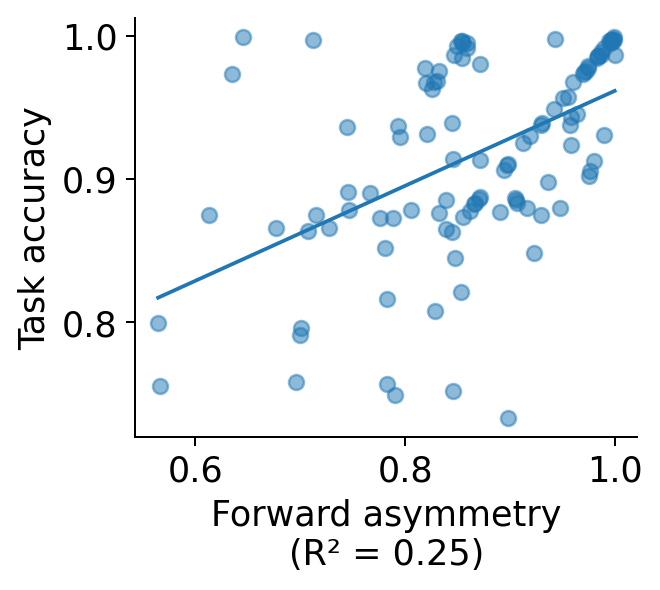

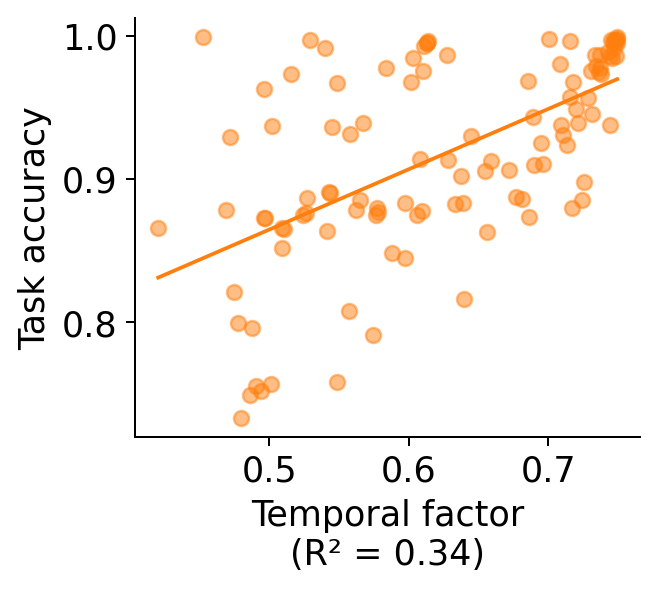

In [17]:
df_tdf_fixed_eta_filtered = df_tdf_fixed_eta[df_tdf_fixed_eta["temporal_factor"] >= 0.4]


plot_scatter(df_tdf_fixed_eta_filtered["forward_asymmetry"], df_tdf_fixed_eta_filtered["accuracy"], "Forward asymmetry", "Task accuracy", color='tab:blue')
plot_scatter(df_tdf_fixed_eta_filtered["temporal_factor"], df_tdf_fixed_eta_filtered["accuracy"], "Temporal factor", "Task accuracy", color='tab:orange')
# plot_scatter(df_tdf_fixed_eta_filtered["index_decoding_accuracy_encoding_phase"], df_tdf_fixed_eta_filtered["accuracy"], "Index decoding accuracy", "Task accuracy", color='tab:green')

### variance explained and cross decoding accuracy

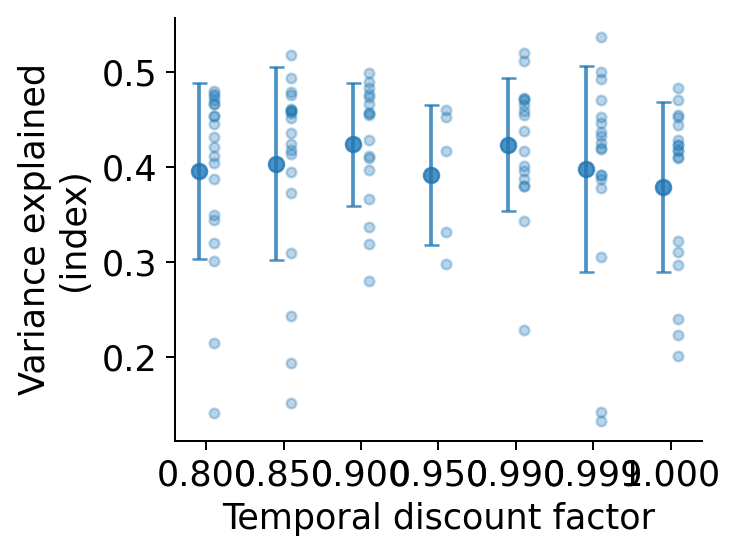

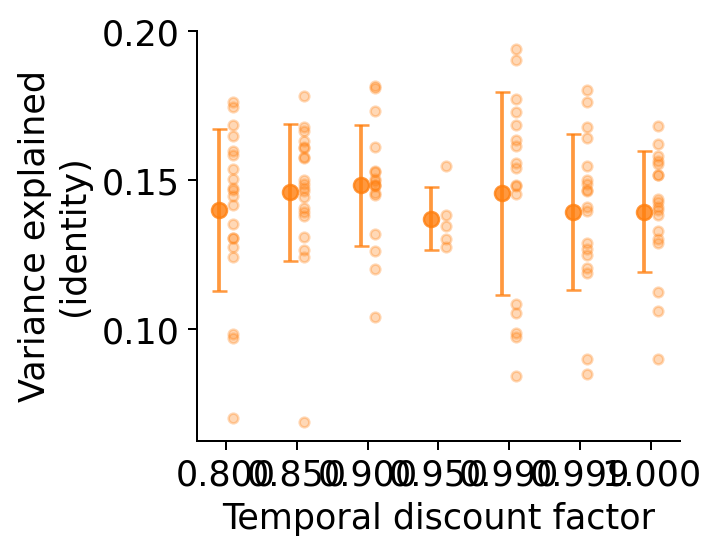

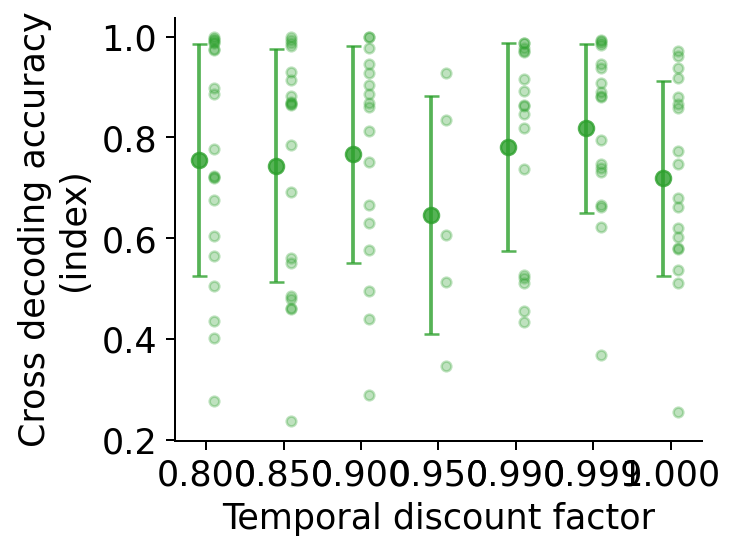

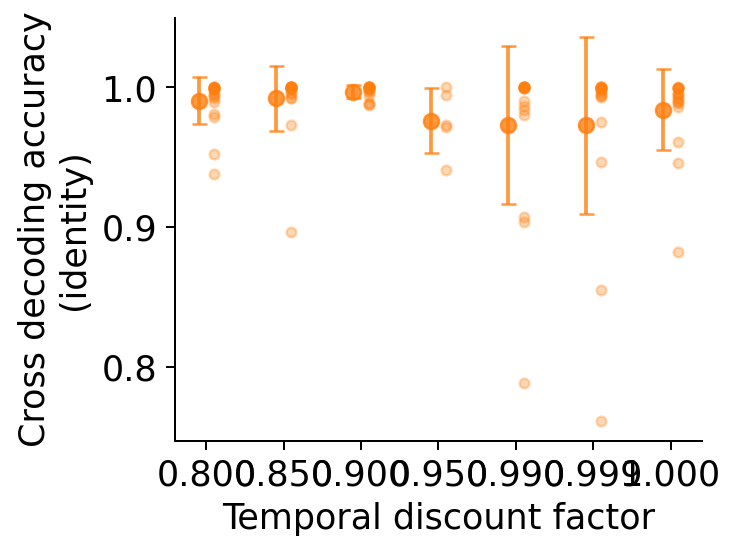

In [19]:
df_tdf_fixed_eta.loc[:, "variance_explained_index"] = (df_tdf_fixed_eta["explained_variance_encoding_index"] + df_tdf_fixed_eta["explained_variance_recall_index"]) / 2
df_tdf_fixed_eta.loc[:, "variance_explained_identity"] = (df_tdf_fixed_eta["explained_variance_encoding_identity"] + df_tdf_fixed_eta["explained_variance_recall_identity"]) / 2

df_tdf_fixed_eta.loc[:, "cross_decoding_accuracy_index"] = (df_tdf_fixed_eta["cross_decoding_accuracy_index_enc_rec"] + df_tdf_fixed_eta["cross_decoding_accuracy_index_rec_enc"]) / 2
df_tdf_fixed_eta.loc[:, "cross_decoding_accuracy_identity"] = (df_tdf_fixed_eta["cross_decoding_accuracy_identity_enc_rec"] + df_tdf_fixed_eta["cross_decoding_accuracy_identity_rec_enc"]) / 2


# change with tdf
tdf_all = df_tdf_fixed_eta["temporal_discount_factor"]
accuracy_all = df_tdf_fixed_eta["accuracy"]
forward_asymmetry_all = df_tdf_fixed_eta["forward_asymmetry"]
temporal_factor_all = df_tdf_fixed_eta["temporal_factor"]
variance_explained_index_all = df_tdf_fixed_eta["variance_explained_index"]
variance_explained_identity_all = df_tdf_fixed_eta["variance_explained_identity"]
cross_decoding_accuracy_index_all = df_tdf_fixed_eta["cross_decoding_accuracy_index"]
cross_decoding_accuracy_identity_all = df_tdf_fixed_eta["cross_decoding_accuracy_identity"]

variance_explained_index_mean_by_tdf = df_tdf_fixed_eta.groupby("temporal_discount_factor")["variance_explained_index"].mean()
variance_explained_identity_mean_by_tdf = df_tdf_fixed_eta.groupby("temporal_discount_factor")["variance_explained_identity"].mean()
cross_decoding_accuracy_index_mean_by_tdf = df_tdf_fixed_eta.groupby("temporal_discount_factor")["cross_decoding_accuracy_index"].mean()
cross_decoding_accuracy_identity_mean_by_tdf = df_tdf_fixed_eta.groupby("temporal_discount_factor")["cross_decoding_accuracy_identity"].mean()

variance_explained_index_std_by_tdf = df_tdf_fixed_eta.groupby("temporal_discount_factor")["variance_explained_index"].std()
variance_explained_identity_std_by_tdf = df_tdf_fixed_eta.groupby("temporal_discount_factor")["variance_explained_identity"].std()
cross_decoding_accuracy_index_std_by_tdf = df_tdf_fixed_eta.groupby("temporal_discount_factor")["cross_decoding_accuracy_index"].std()
cross_decoding_accuracy_identity_std_by_tdf = df_tdf_fixed_eta.groupby("temporal_discount_factor")["cross_decoding_accuracy_identity"].std()


plot_mean_std_scatter(temporal_discount_factors, variance_explained_index_mean_by_tdf, variance_explained_index_std_by_tdf, 
                      tdf_all, variance_explained_index_all, "Temporal discount factor", "Variance explained\n(index)", color='tab:blue')

plot_mean_std_scatter(temporal_discount_factors, variance_explained_identity_mean_by_tdf, variance_explained_identity_std_by_tdf, 
                      tdf_all, variance_explained_identity_all, "Temporal discount factor", "Variance explained\n(identity)", color='tab:orange')

plot_mean_std_scatter(temporal_discount_factors, cross_decoding_accuracy_index_mean_by_tdf, cross_decoding_accuracy_index_std_by_tdf, 
                      tdf_all, cross_decoding_accuracy_index_all, "Temporal discount factor", "Cross decoding accuracy\n(index)", color='tab:green')

plot_mean_std_scatter(temporal_discount_factors, cross_decoding_accuracy_identity_mean_by_tdf, cross_decoding_accuracy_identity_std_by_tdf, 
                      tdf_all, cross_decoding_accuracy_identity_all, "Temporal discount factor", "Cross decoding accuracy\n(identity)", color='tab:orange')


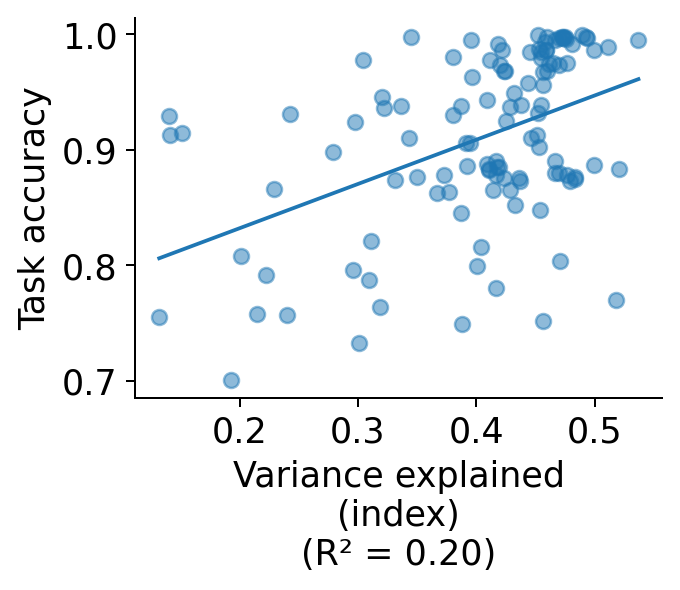

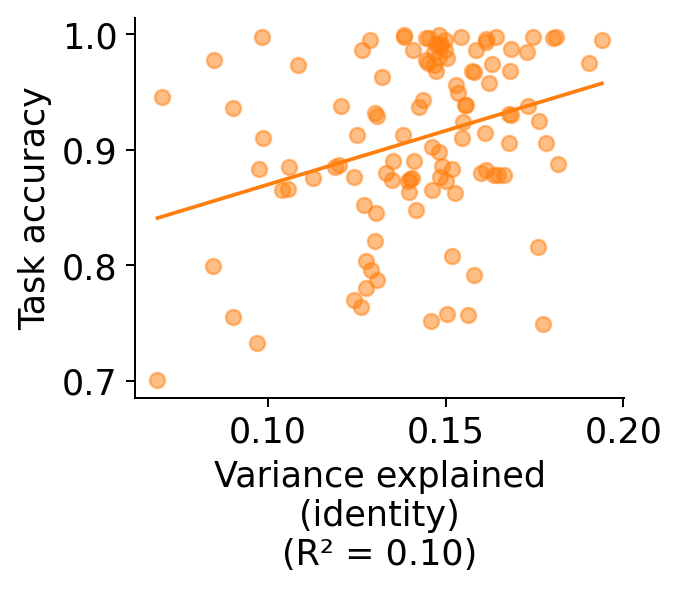

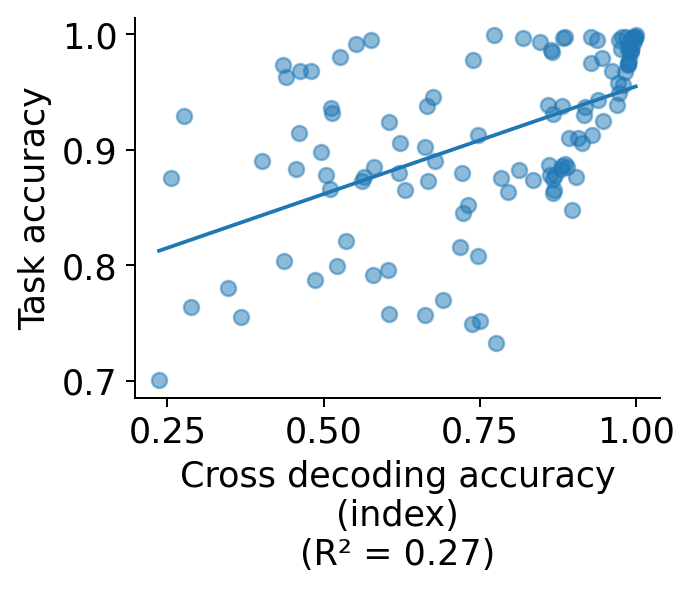

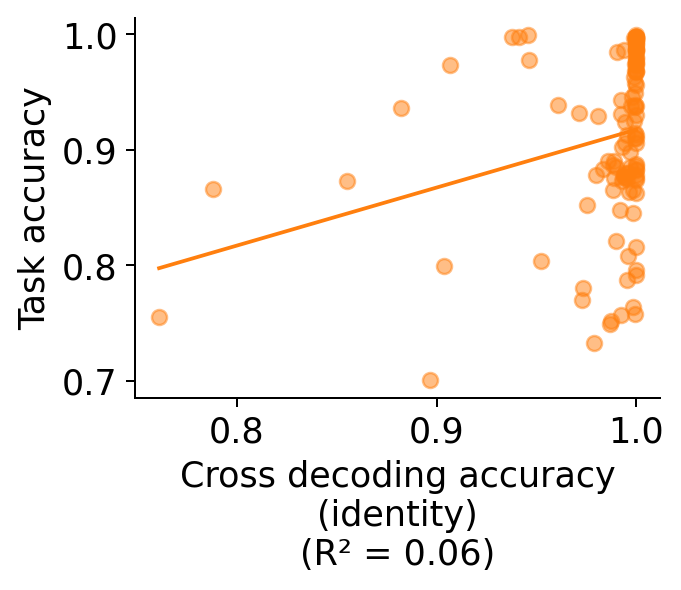

In [20]:

plot_scatter(df_tdf_fixed_eta["variance_explained_index"], df_tdf_fixed_eta["accuracy"], "Variance explained\n(index)", "Task accuracy", color='tab:blue')
plot_scatter(df_tdf_fixed_eta["variance_explained_identity"], df_tdf_fixed_eta["accuracy"], "Variance explained\n(identity)", "Task accuracy", color='tab:orange')
plot_scatter(df_tdf_fixed_eta["cross_decoding_accuracy_index"], df_tdf_fixed_eta["accuracy"], "Cross decoding accuracy\n(index)", "Task accuracy", color='tab:blue')
plot_scatter(df_tdf_fixed_eta["cross_decoding_accuracy_identity"], df_tdf_fixed_eta["accuracy"], "Cross decoding accuracy\n(identity)", "Task accuracy", color='tab:orange')

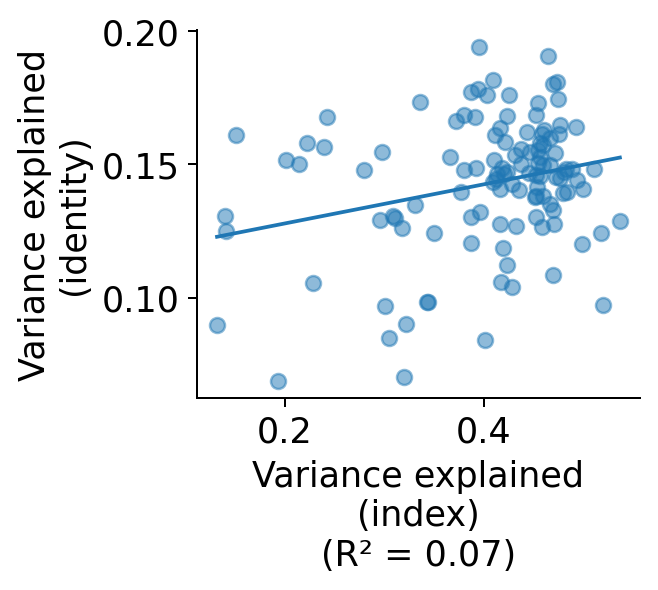

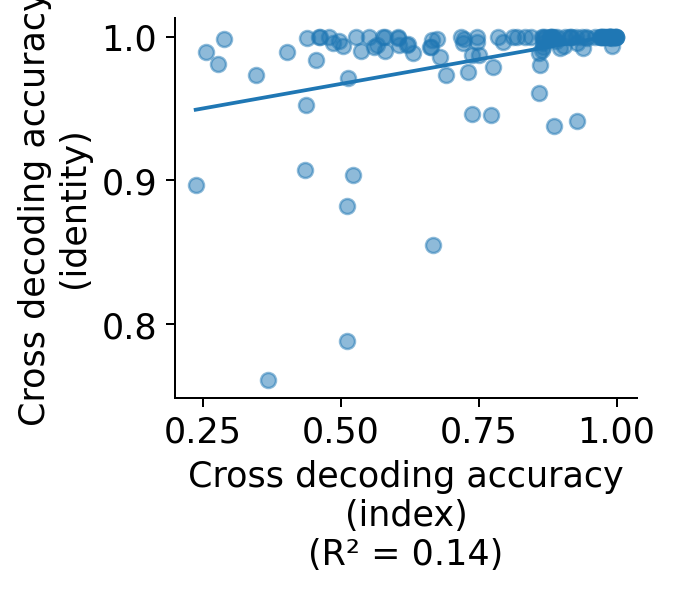

In [23]:
df_tdf_fixed_eta_high_perf = df_tdf_fixed_eta[df_tdf_fixed_eta["accuracy"] >= 0.7]

# relation between explained variance and cross decoding accuracy
plot_scatter(df_tdf_fixed_eta_high_perf["variance_explained_index"], df_tdf_fixed_eta_high_perf["variance_explained_identity"], "Variance explained\n(index)", "Variance explained\n(identity)", color='tab:blue')
plot_scatter(df_tdf_fixed_eta_high_perf["cross_decoding_accuracy_index"], df_tdf_fixed_eta_high_perf["cross_decoding_accuracy_identity"], "Cross decoding accuracy\n(index)", "Cross decoding accuracy\n(identity)", color='tab:blue')

## Vary eta

In [5]:
df_tdf_vary_eta = df_tdf[(df_tdf["pretrained"] == False) & (df_tdf["temporal_discount_factor"] == 1.0) & (df_tdf["accuracy"] >= 0.7)]

### training curve

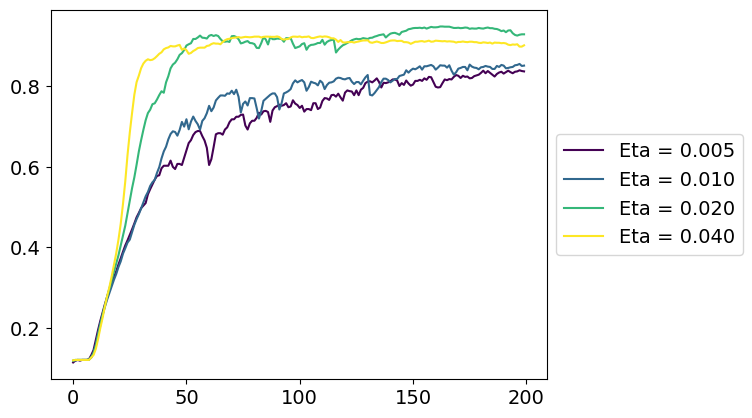

In [10]:
training_accuracy_by_eta = df_tdf_vary_eta.groupby("eta")["training_accuracy"].mean()

colors = plt.cm.viridis(np.linspace(0, 1, len(training_accuracy_by_eta)))
for i, (eta, acc) in enumerate(training_accuracy_by_eta.items()):
    plt.plot(acc[:200], label=f"Eta = {eta:.3f}", color=colors[i])
# set the legend to the right of the plot
ax = plt.gca()
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

### metrics changing with eta

In [6]:
accuracy_mean_by_eta = df_tdf_vary_eta.groupby("eta")["accuracy"].mean()
accuracy_std_by_eta = df_tdf_vary_eta.groupby("eta")["accuracy"].std()

temporal_factor_mean_by_eta = df_tdf_vary_eta.groupby("eta")["temporal_factor"].mean()
temporal_factor_std_by_eta = df_tdf_vary_eta.groupby("eta")["temporal_factor"].std()

forward_asymmetry_mean_by_eta = df_tdf_vary_eta.groupby("eta")["forward_asymmetry"].mean()
forward_asymmetry_std_by_eta = df_tdf_vary_eta.groupby("eta")["forward_asymmetry"].std()

eta_all = df_tdf_vary_eta["eta"]
accuracy_all = df_tdf_vary_eta["accuracy"]
forward_asymmetry_all = df_tdf_vary_eta["forward_asymmetry"]
temporal_factor_all = df_tdf_vary_eta["temporal_factor"]


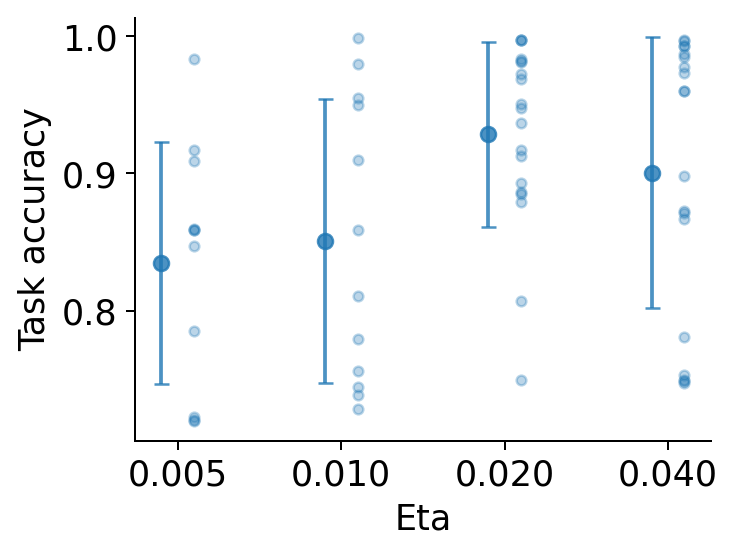

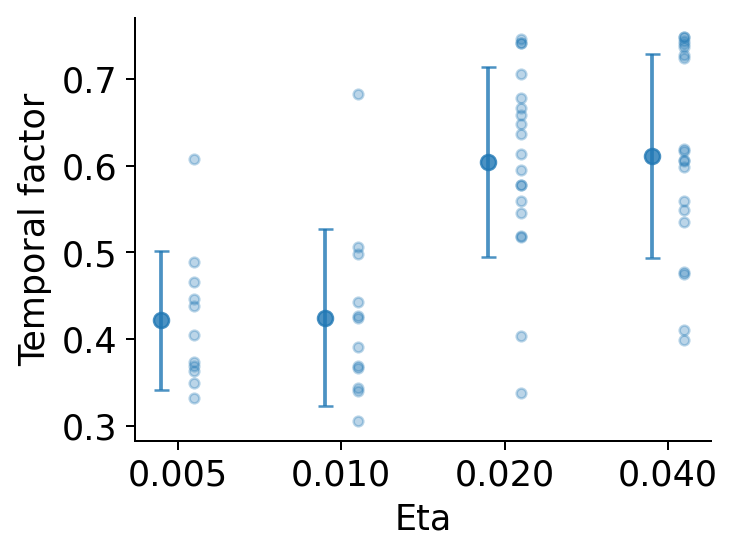

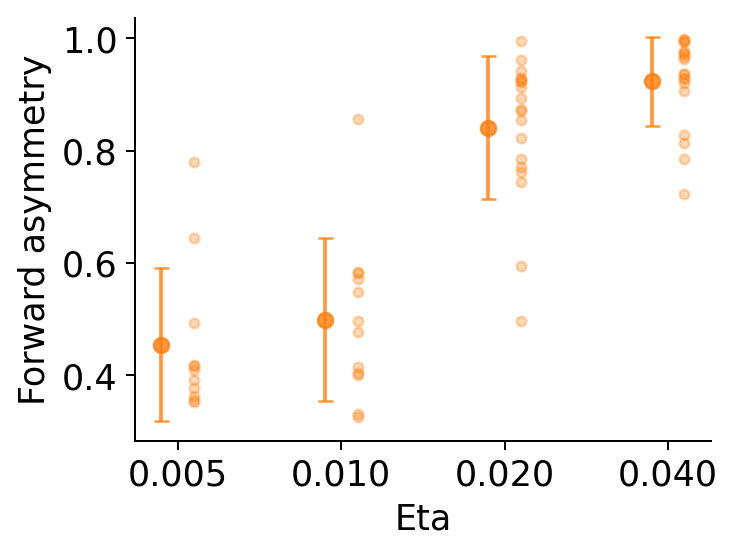

In [7]:

plot_mean_std_scatter_eta(etas, accuracy_mean_by_eta, accuracy_std_by_eta, eta_all, accuracy_all, "Eta", "Task accuracy", color='tab:blue')
plot_mean_std_scatter_eta(etas, temporal_factor_mean_by_eta, temporal_factor_std_by_eta, eta_all, temporal_factor_all, "Eta", "Temporal factor", color='tab:blue')
plot_mean_std_scatter_eta(etas, forward_asymmetry_mean_by_eta, forward_asymmetry_std_by_eta, eta_all, forward_asymmetry_all, "Eta", "Forward asymmetry", color='tab:orange')


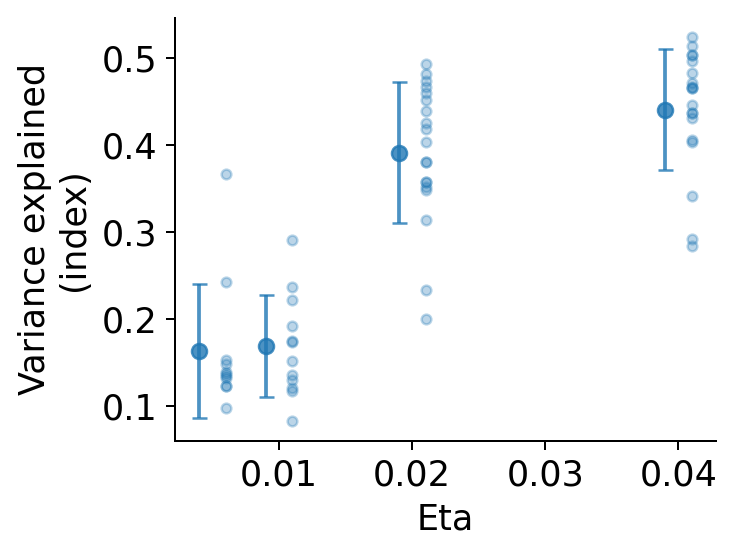

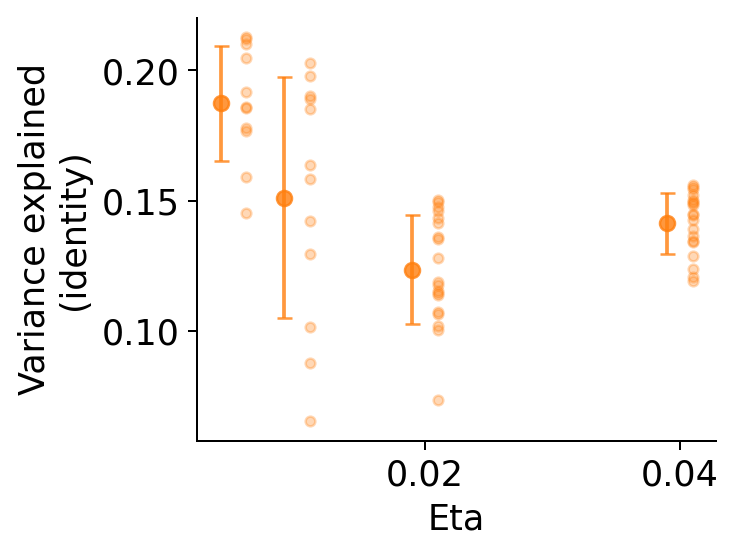

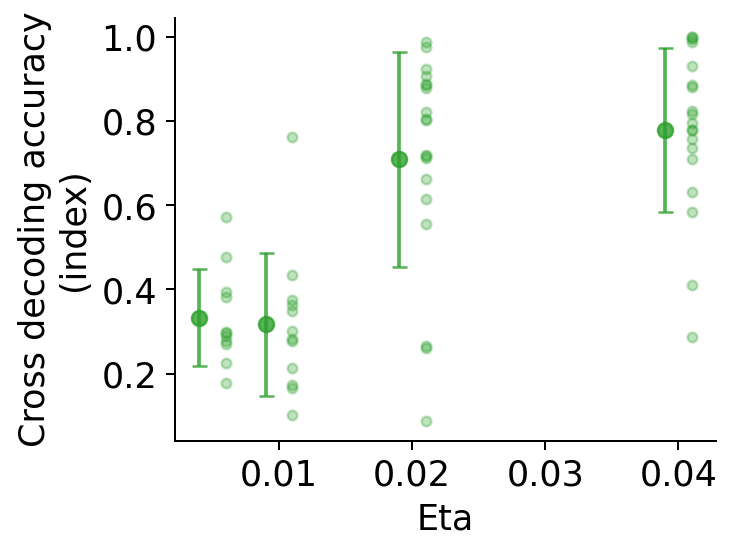

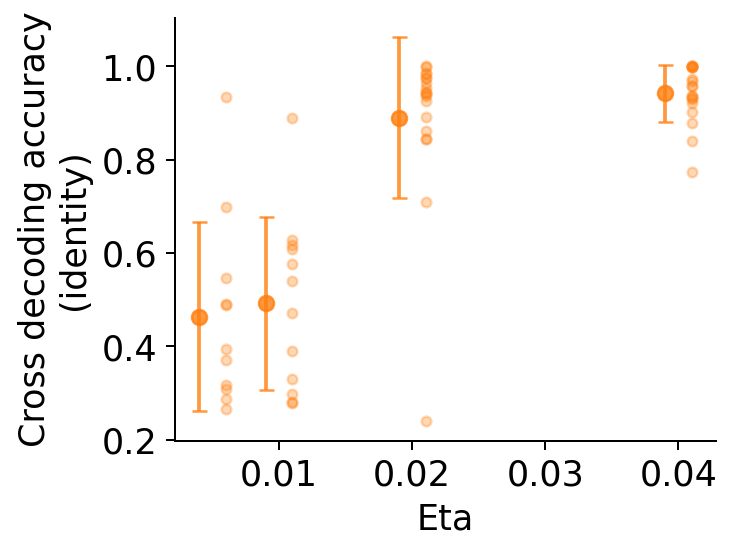

In [9]:
df_tdf_vary_eta.loc[:, "variance_explained_index"] = (df_tdf_vary_eta["explained_variance_encoding_index"] + df_tdf_vary_eta["explained_variance_recall_index"]) / 2
df_tdf_vary_eta.loc[:, "variance_explained_identity"] = (df_tdf_vary_eta["explained_variance_encoding_identity"] + df_tdf_vary_eta["explained_variance_recall_identity"]) / 2

df_tdf_vary_eta.loc[:, "cross_decoding_accuracy_index"] = (df_tdf_vary_eta["cross_decoding_accuracy_index_enc_rec"] + df_tdf_vary_eta["cross_decoding_accuracy_index_rec_enc"]) / 2
df_tdf_vary_eta.loc[:, "cross_decoding_accuracy_identity"] = (df_tdf_vary_eta["cross_decoding_accuracy_identity_enc_rec"] + df_tdf_vary_eta["cross_decoding_accuracy_identity_rec_enc"]) / 2

variance_explained_index_mean_by_eta = df_tdf_vary_eta.groupby("eta")["variance_explained_index"].mean()
variance_explained_index_std_by_eta = df_tdf_vary_eta.groupby("eta")["variance_explained_index"].std()
variance_explained_identity_mean_by_eta = df_tdf_vary_eta.groupby("eta")["variance_explained_identity"].mean()
variance_explained_identity_std_by_eta = df_tdf_vary_eta.groupby("eta")["variance_explained_identity"].std()

cross_decoding_accuracy_index_mean_by_eta = df_tdf_vary_eta.groupby("eta")["cross_decoding_accuracy_index"].mean()
cross_decoding_accuracy_index_std_by_eta = df_tdf_vary_eta.groupby("eta")["cross_decoding_accuracy_index"].std()
cross_decoding_accuracy_identity_mean_by_eta = df_tdf_vary_eta.groupby("eta")["cross_decoding_accuracy_identity"].mean()
cross_decoding_accuracy_identity_std_by_eta = df_tdf_vary_eta.groupby("eta")["cross_decoding_accuracy_identity"].std()

variance_explained_index_all = df_tdf_vary_eta["variance_explained_index"]
variance_explained_identity_all = df_tdf_vary_eta["variance_explained_identity"]
cross_decoding_accuracy_index_all = df_tdf_vary_eta["cross_decoding_accuracy_index"]
cross_decoding_accuracy_identity_all = df_tdf_vary_eta["cross_decoding_accuracy_identity"]


plot_mean_std_scatter(etas, variance_explained_index_mean_by_eta, variance_explained_index_std_by_eta, eta_all, variance_explained_index_all, "Eta", "Variance explained\n(index)", color='tab:blue', vary_x=0.001)
plot_mean_std_scatter(etas, variance_explained_identity_mean_by_eta, variance_explained_identity_std_by_eta, eta_all, variance_explained_identity_all, "Eta", "Variance explained\n(identity)", color='tab:orange', vary_x=0.001)
plot_mean_std_scatter(etas, cross_decoding_accuracy_index_mean_by_eta, cross_decoding_accuracy_index_std_by_eta, eta_all, cross_decoding_accuracy_index_all, "Eta", "Cross decoding accuracy\n(index)", color='tab:green', vary_x=0.001)
plot_mean_std_scatter(etas, cross_decoding_accuracy_identity_mean_by_eta, cross_decoding_accuracy_identity_std_by_eta, eta_all, cross_decoding_accuracy_identity_all, "Eta", "Cross decoding accuracy\n(identity)", color='tab:orange', vary_x=0.001)



### scatter plots between metrics

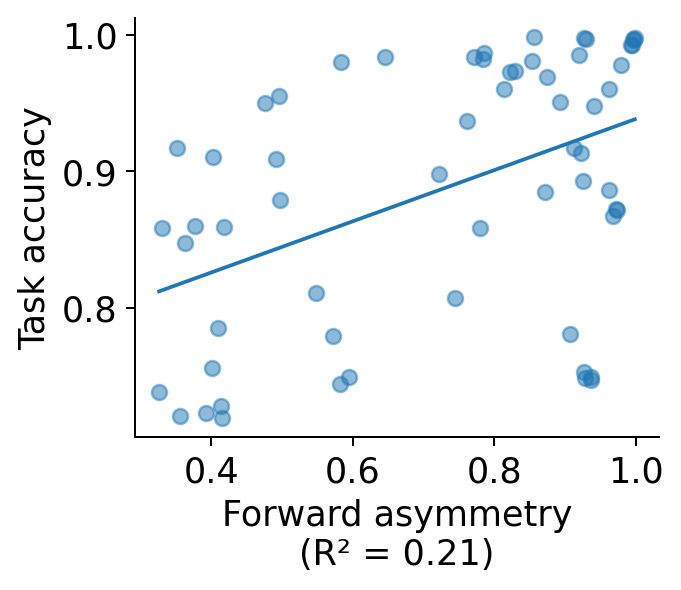

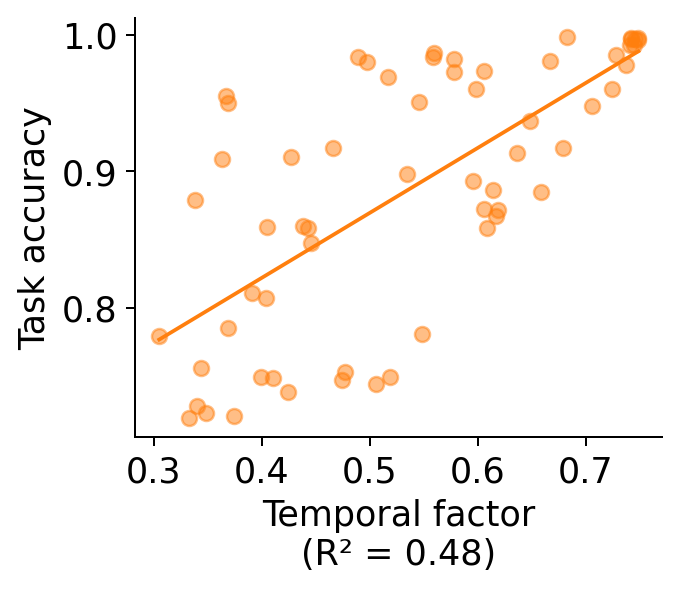

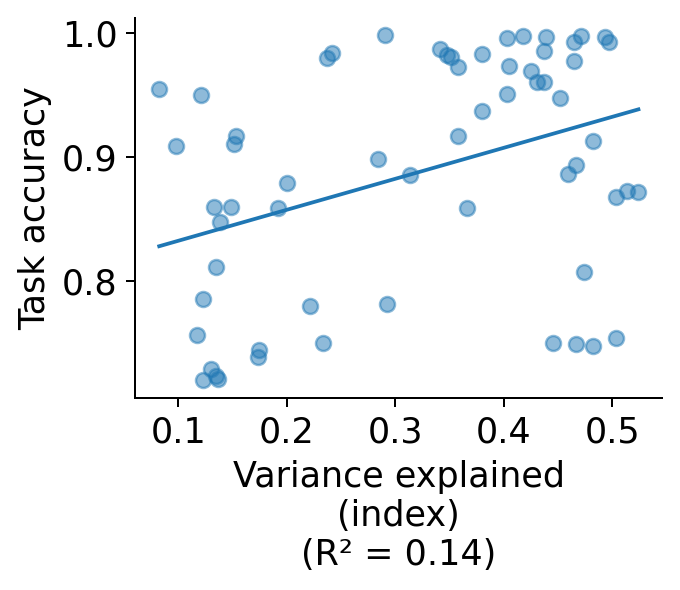

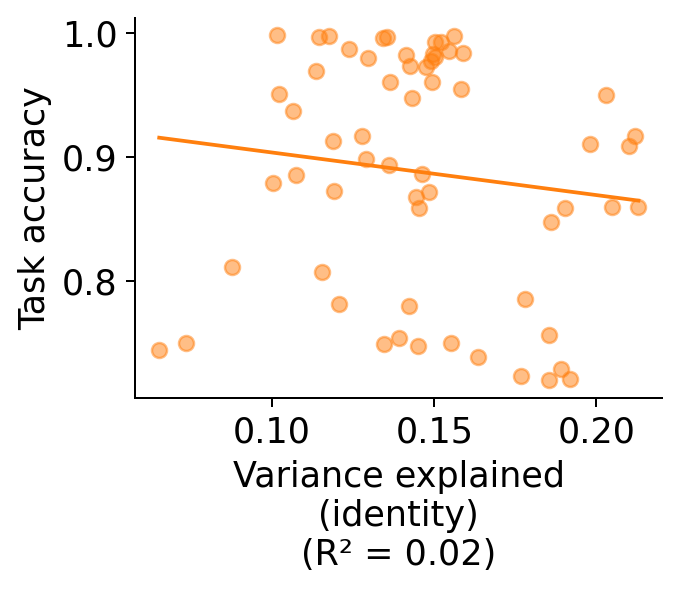

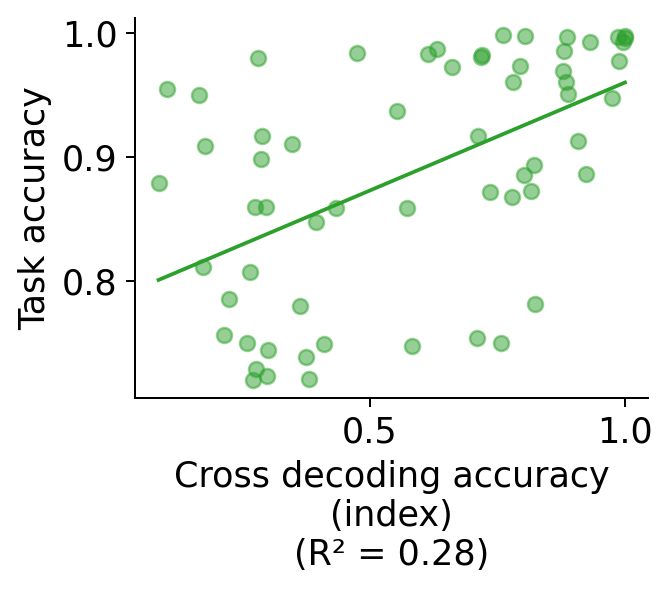

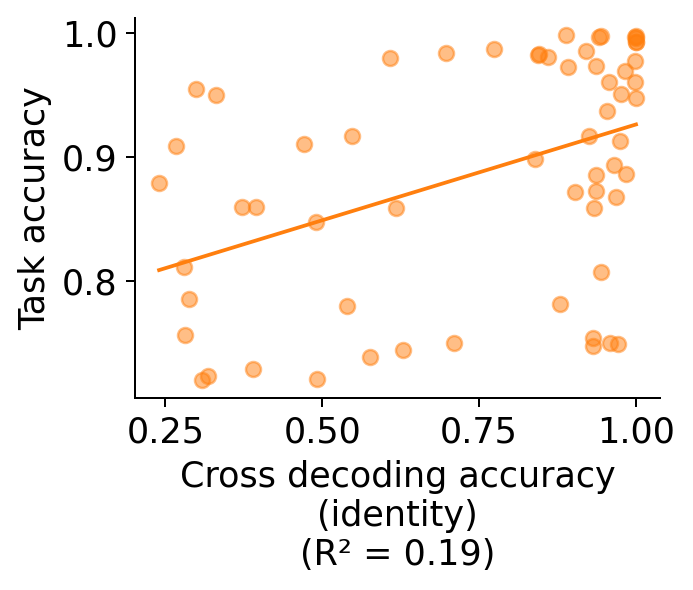

In [10]:
# metrics and accuracy
plot_scatter(df_tdf_vary_eta["forward_asymmetry"], df_tdf_vary_eta["accuracy"], "Forward asymmetry", "Task accuracy", color='tab:blue')
plot_scatter(df_tdf_vary_eta["temporal_factor"], df_tdf_vary_eta["accuracy"], "Temporal factor", "Task accuracy", color='tab:orange')
plot_scatter(df_tdf_vary_eta["variance_explained_index"], df_tdf_vary_eta["accuracy"], "Variance explained\n(index)", "Task accuracy", color='tab:blue')
plot_scatter(df_tdf_vary_eta["variance_explained_identity"], df_tdf_vary_eta["accuracy"], "Variance explained\n(identity)", "Task accuracy", color='tab:orange')
plot_scatter(df_tdf_vary_eta["cross_decoding_accuracy_index"], df_tdf_vary_eta["accuracy"], "Cross decoding accuracy\n(index)", "Task accuracy", color='tab:green')
plot_scatter(df_tdf_vary_eta["cross_decoding_accuracy_identity"], df_tdf_vary_eta["accuracy"], "Cross decoding accuracy\n(identity)", "Task accuracy", color='tab:orange')


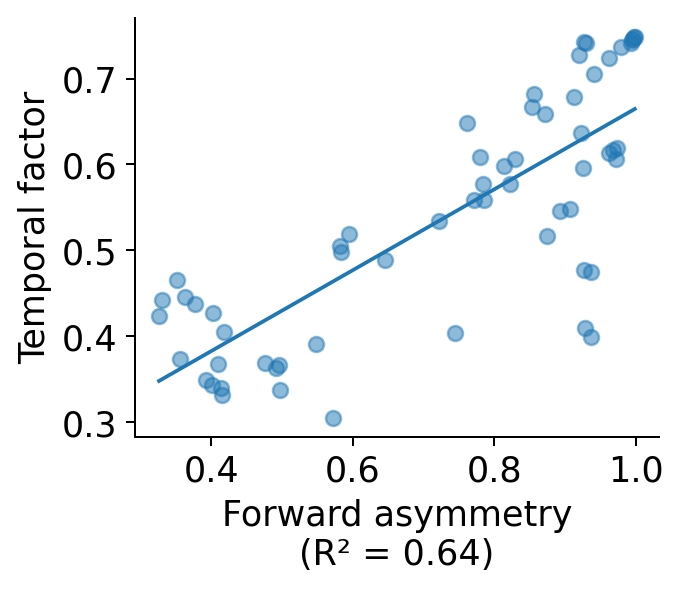

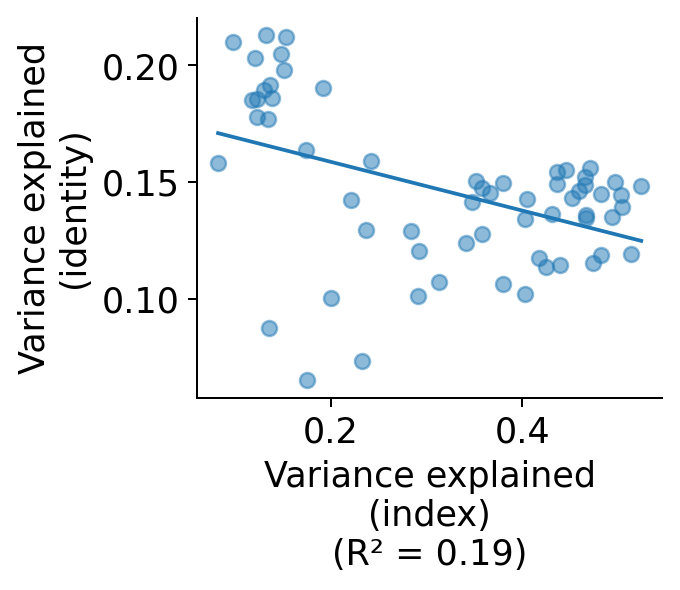

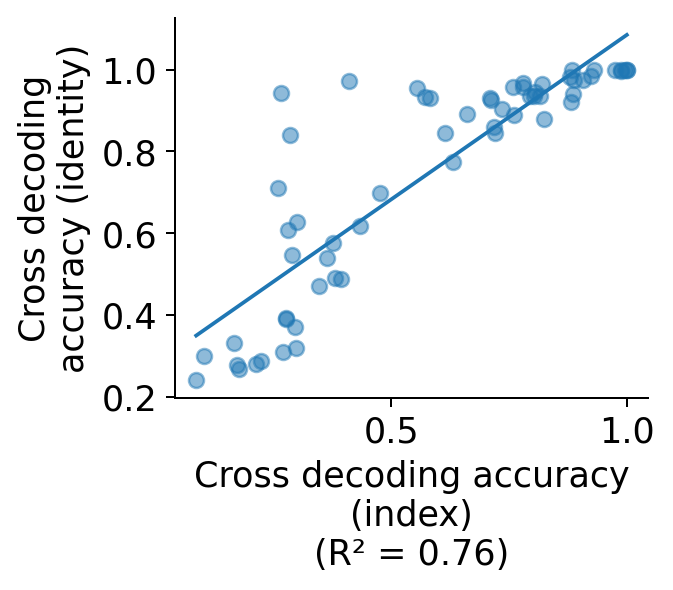

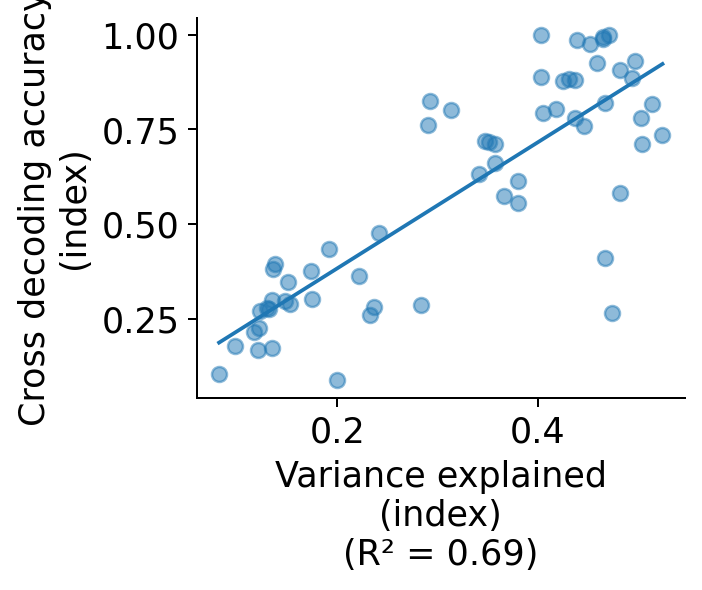

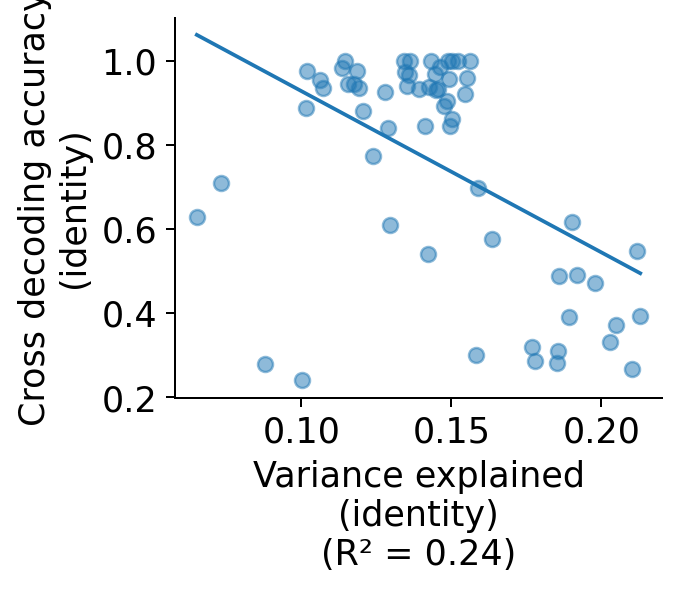

In [13]:
plot_scatter(df_tdf_vary_eta["forward_asymmetry"], df_tdf_vary_eta["temporal_factor"], "Forward asymmetry", "Temporal factor", color='tab:blue')
plot_scatter(df_tdf_vary_eta["variance_explained_index"], df_tdf_vary_eta["variance_explained_identity"], "Variance explained\n(index)", "Variance explained\n(identity)", color='tab:blue')
plot_scatter(df_tdf_vary_eta["cross_decoding_accuracy_index"], df_tdf_vary_eta["cross_decoding_accuracy_identity"], "Cross decoding accuracy\n(index)", "Cross decoding\naccuracy (identity)", color='tab:blue')

plot_scatter(df_tdf_vary_eta["variance_explained_index"], df_tdf_vary_eta["cross_decoding_accuracy_index"], "Variance explained\n(index)", "Cross decoding accuracy\n(index)", color='tab:blue')
plot_scatter(df_tdf_vary_eta["variance_explained_identity"], df_tdf_vary_eta["cross_decoding_accuracy_identity"], "Variance explained\n(identity)", "Cross decoding accuracy\n(identity)", color='tab:blue')

## all data scatter plot

In [24]:
df_tdf_filtered = df_tdf[(df_tdf["accuracy"] >= 0.7) & (df_tdf["temporal_discount_factor"] >= 0.4) & (df_tdf["pretrained"] == False) & (df_tdf["temporal_discount_factor"] == 1.0) & (df_tdf["eta"] == 0.01)]

df_tdf_filtered.loc[:, "variance_explained_index"] = (df_tdf_filtered["explained_variance_encoding_index"] + df_tdf_filtered["explained_variance_recall_index"]) / 2
df_tdf_filtered.loc[:, "variance_explained_identity"] = (df_tdf_filtered["explained_variance_encoding_identity"] + df_tdf_filtered["explained_variance_recall_identity"]) / 2
df_tdf_filtered.loc[:, "cross_decoding_accuracy_index"] = (df_tdf_filtered["cross_decoding_accuracy_index_enc_rec"] + df_tdf_filtered["cross_decoding_accuracy_index_rec_enc"]) / 2
df_tdf_filtered.loc[:, "cross_decoding_accuracy_identity"] = (df_tdf_filtered["cross_decoding_accuracy_identity_enc_rec"] + df_tdf_filtered["cross_decoding_accuracy_identity_rec_enc"]) / 2

plot_scatter(df_tdf_filtered["forward_asymmetry"], df_tdf_filtered["accuracy"], "Forward asymmetry", "Task accuracy", color='tab:blue')
plot_scatter(df_tdf_filtered["temporal_factor"], df_tdf_filtered["accuracy"], "Temporal factor", "Task accuracy", color='tab:orange')
plot_scatter(df_tdf_filtered["variance_explained_index"], df_tdf_filtered["accuracy"], "Variance explained\n(index)", "Task accuracy", color='tab:blue')
plot_scatter(df_tdf_filtered["variance_explained_identity"], df_tdf_filtered["accuracy"], "Variance explained\n(identity)", "Task accuracy", color='tab:orange')
plot_scatter(df_tdf_filtered["cross_decoding_accuracy_index"], df_tdf_filtered["accuracy"], "Cross decoding accuracy\n(index)", "Task accuracy", color='tab:green')
plot_scatter(df_tdf_filtered["cross_decoding_accuracy_identity"], df_tdf_filtered["accuracy"], "Cross decoding accuracy\n(identity)", "Task accuracy", color='tab:orange')


## clustering analysis

In [5]:
df_tdf_filtered = df_tdf[(df_tdf["accuracy"] >= 0.7) & (df_tdf["temporal_discount_factor"] >= 0.4) & (df_tdf["pretrained"] == False) & (df_tdf["temporal_discount_factor"] == 1.0)]
# df_tdf_filtered = df_tdf[(df_tdf["accuracy"] >= 0.7) & (df_tdf["temporal_discount_factor"] >= 0.4) & (df_tdf["pretrained"] == True)]

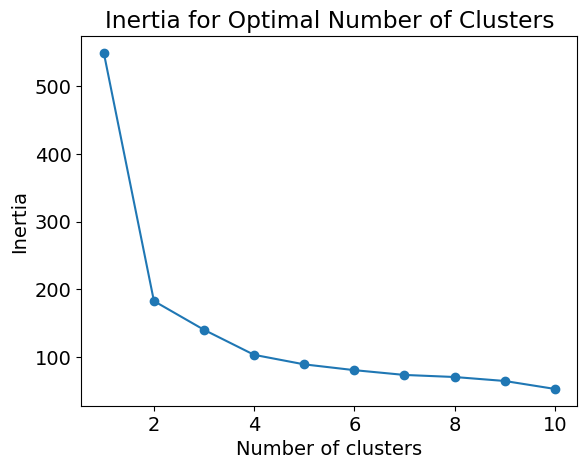

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

features = ["forward_asymmetry", "temporal_factor", "index_decoding_accuracy", "item_decoding_accuracy", "last_item_decoding_accuracy", "explained_variance_index", 
            "explained_variance_identity", "cross_decoding_accuracy_index", "cross_decoding_accuracy_identity"]

X = df_tdf_filtered[features]

scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Determine the optimal number of clusters with elbow method
inertia = []
for n_clusters in range(1, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X_normalized)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Inertia for Optimal Number of Clusters')
plt.show()



In [8]:

# Fit the KMeans model with the optimal number of clusters
optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X_normalized)
df_tdf_filtered.loc[:, 'cluster'] = cluster_labels

# Add silhouette score to evaluate clustering quality
silhouette_avg = silhouette_score(X_normalized, cluster_labels)
print(f'Silhouette Score for {optimal_clusters} clusters: {silhouette_avg}')


Silhouette Score for 3 clusters: 0.4790003098774335


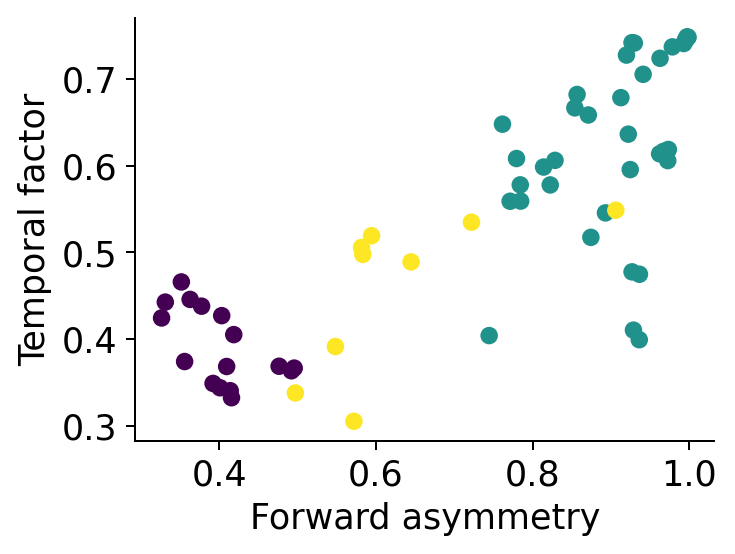

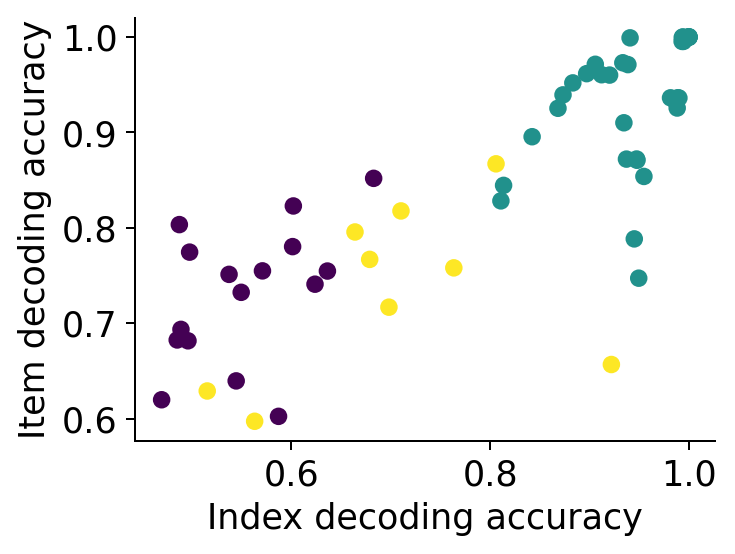

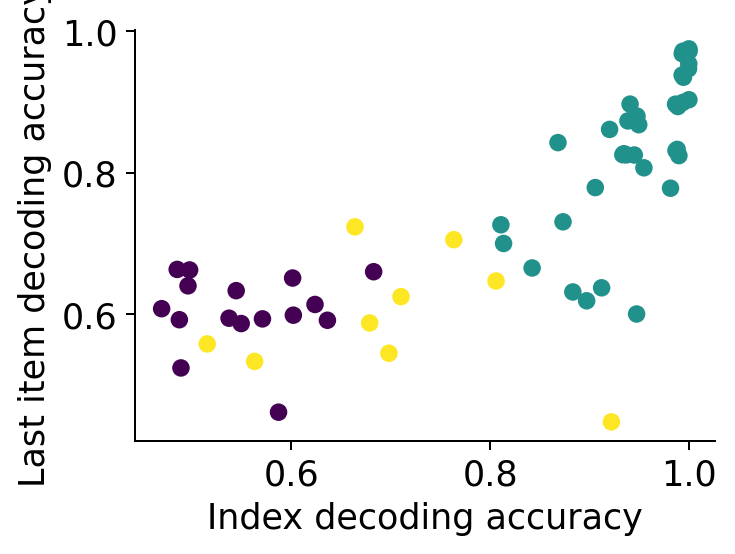

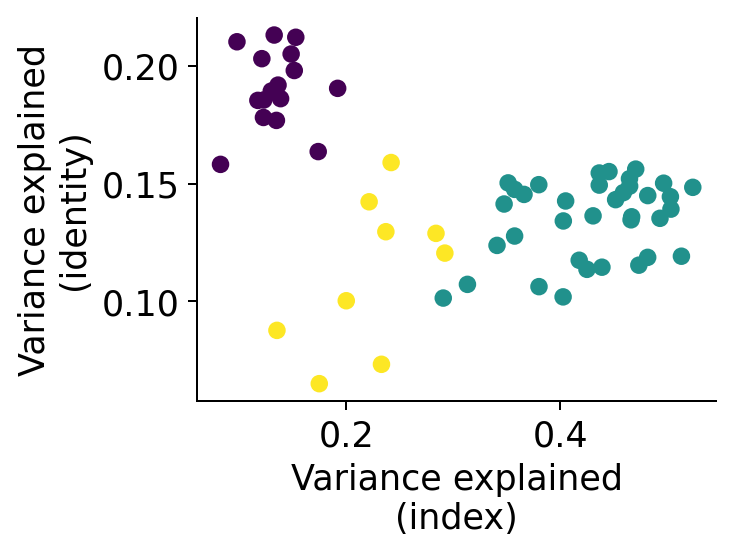

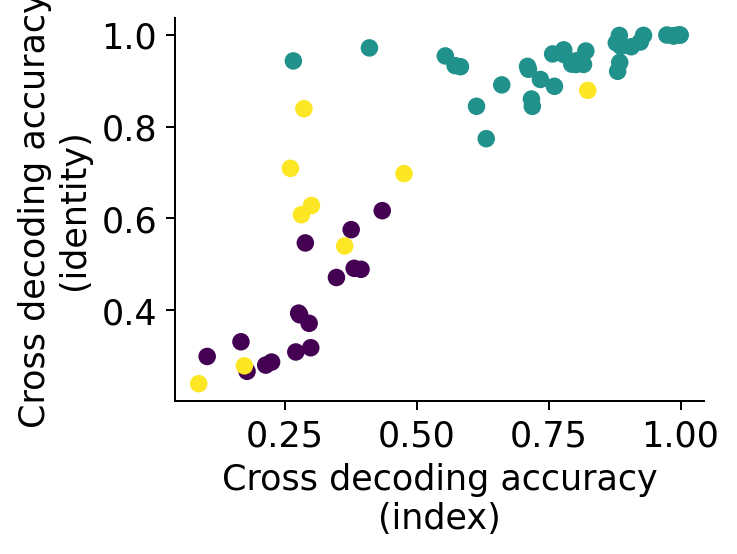

In [9]:
# plot scatter with cluster labels
def plot_scatter_cluster(df, x, y, c, x_label, y_label):
    plt.figure(figsize=(4.3, 3.3), dpi=180)
    plt.scatter(df[x], df[y], c=df[c])
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()
    plt.show()

plot_scatter_cluster(df_tdf_filtered, 'forward_asymmetry', 'temporal_factor', 'cluster', 'Forward asymmetry', 'Temporal factor')
plot_scatter_cluster(df_tdf_filtered, 'index_decoding_accuracy', 'item_decoding_accuracy', 'cluster', 'Index decoding accuracy', 'Item decoding accuracy')
plot_scatter_cluster(df_tdf_filtered, 'index_decoding_accuracy', 'last_item_decoding_accuracy', 'cluster', 'Index decoding accuracy', 'Last item decoding accuracy')
plot_scatter_cluster(df_tdf_filtered, 'explained_variance_index', 'explained_variance_identity', 'cluster', 'Variance explained\n(index)', 'Variance explained\n(identity)')
plot_scatter_cluster(df_tdf_filtered, 'cross_decoding_accuracy_index', 'cross_decoding_accuracy_identity', 'cluster', 'Cross decoding accuracy\n(index)', 'Cross decoding accuracy\n(identity)')


In [16]:
# print 5 info for each cluster
for i in range(optimal_clusters):
    print(f'Cluster {i+1}:')
    print(df_tdf_filtered[df_tdf_filtered['cluster'] == i][["temporal_discount_factor", "eta", "model_num"]].head())

Cluster 1:
     temporal_discount_factor    eta  model_num
798                       1.0  0.005          0
800                       1.0  0.005          1
806                       1.0  0.005          4
808                       1.0  0.005          5
816                       1.0  0.005          9
Cluster 2:
     temporal_discount_factor    eta  model_num
804                       1.0  0.005          3
858                       1.0  0.010         10
880                       1.0  0.020          1
884                       1.0  0.020          3
886                       1.0  0.020          4
Cluster 3:
     temporal_discount_factor    eta  model_num
824                       1.0  0.005         13
844                       1.0  0.010          3
848                       1.0  0.010          5
854                       1.0  0.010          8
856                       1.0  0.010          9
